# Enron Dataset Analysis
<hr>
**Author:** *Gilberto Diaz*

In [105]:
import pandas as pd
import re
import email
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('enron').getOrCreate()

### Loading enron dataset

In [2]:
data = pd.read_csv('./emails.csv')
data.shape

(517401, 2)

Over half million rows and two columns.

In [3]:
data.columns

Index(['file', 'message'], dtype='object')

In [4]:
print(data['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


Looks like the message has the [RFC822](https://www.w3.org/Protocols/rfc822/) message protocol. Researching in [Kaggle](http://www.kaggle.com) the Enron dataset I found that [Python](http://www.python.org) has a library to parse messages in RFC822 format and the documentation is [here](https://docs.python.org/3.4/library/email.message.html#email.message.Message.walk). Since the `message` column has the most useful content, lets start working with that column.

Parsing the string into an email object - documentation [here](https://docs.python.org/3.4/library/email.parser.html?highlight=message_from_string#email.message_from_string).

In [5]:
emails = list(map(email.message_from_string, data['message']))

In [6]:
print(len(emails))
emails[0]

517401


Now I have each row in a email object.

### Transforming email object into data frame.

In [7]:
print(emails[0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


The email parser would take each row header as key (`Message-ID`, `Date`, `From`, `To`, etc). We are going to use those keys to iterate over each row object and extract the data. Each key will become column names and the respective values as rows.

In [8]:
emails_key = emails[0].keys()
emails_key

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

The actual content of the email doesn't have a key therefore that key is not present in the `list`. We are going to get that content with `get_payload()` method from the email package.

In [9]:
df = pd.DataFrame()
for key in emails_key:
    df[key] = [col_value[key] for col_value in emails]
    df['email_body'] = [email_content.get_payload() for email_content in emails]
    df['user'] = data['file'].map(lambda file_path: file_path.split('/')[0])

In [10]:
df.head(1)

,Message-ID,email_body,user,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,allen-p,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst


In [11]:
df.drop(['Content-Transfer-Encoding', 'Content-Type', 'Mime-Version'], axis=1, inplace=True)
df.head(1)

,Message-ID,email_body,user,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,allen-p,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst


In [12]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.head(1)

,Message-ID,email_body,user,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,allen-p,2001-05-14 23:39:00,phillip.allen@enron.com,tim.belden@enron.com,,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst


In [13]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
sb.set()

Text(0,0.5,'# Emails')

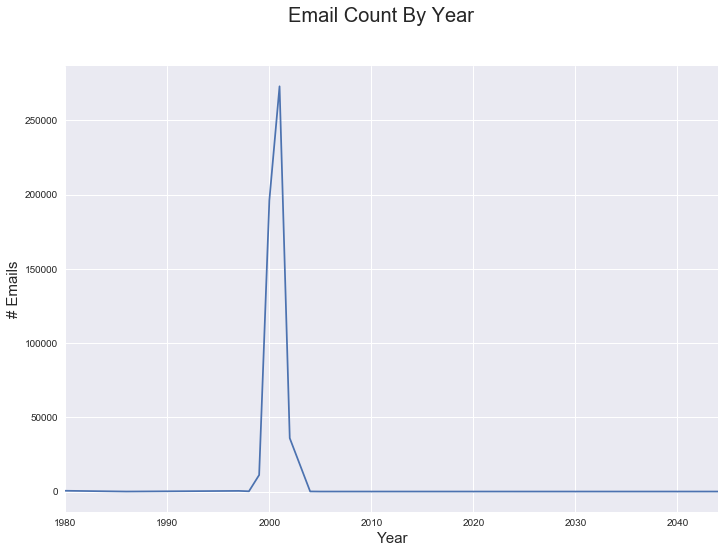

In [14]:
dims = (11.7, 8.2)
fig, ax = plt.subplots(figsize=dims)
ax.figure.suptitle('Email Count By Year', fontsize=20)
ax = df.groupby(df['Date'].dt.year)['email_body'].count().plot()
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('# Emails', fontsize=15)

It is a spike in the amount of emails around 2001. Based on [this article](http://www.corpwatch.org/article.php?id=2278), that is the time when Enron discloses it has overstated its earnings by $600 million, dating back to 1997.

### Analyzing counts

In [15]:
user_count = df['user'].value_counts().to_frame()
user_count.reset_index(inplace=True)
user_count.rename(columns={'index': 'User', 'user': 'User Count'}, inplace=True)
user_count.sort_values('User Count', ascending=False, inplace=True)
user_count.head()

,User,User Count
0,kaminski-v,28465
1,dasovich-j,28234
2,kean-s,25351
3,mann-k,23381
4,jones-t,19950


In [16]:
user_count['User Count'].sum()

517401

The `From` and `file` which became `user` have the same count.

In [17]:
kaminski = df[['user', 'From', 'X-Origin']]
kaminski = kaminski[kaminski['user'] == 'kaminski-v']

In [18]:
print(kaminski.columns)
kaminski.shape

Index(['user', 'From', 'X-Origin'], dtype='object')


(28465, 3)

In [19]:
print(f'Same user => {kaminski["user"].unique()[0]}')
print(f'With two origin accounts => {kaminski["X-Origin"].unique()[0]}, {kaminski["X-Origin"].unique()[1]}')
print(f'Used {kaminski["From"].nunique()} different email addresses to send emails.')

Same user => kaminski-v
With two origin accounts => Kaminski-V, KAMINSKI-V
Used 1503 different email addresses to send emails.


### TODO:
- What `X-Origin` means.

In [20]:
sub_df = df[['user', 'From', 'X-Origin']]
sub_df = sub_df.groupby('user').nunique()
sub_df.rename_axis('User', inplace=True)
sub_df = sub_df.rename(columns={
    'user': 'User Count'
})
sub_df.reset_index(inplace=True)
sub_df = sub_df.rename(columns={
    'user': 'User'
})
sub_df.sort_values('From', ascending=False)

,User,User Count,From,X-Origin
63,lay-k,1,2200,2
55,kaminski-v,1,1503,2
19,dasovich-j,1,1146,3
132,taylor-m,1,975,1
118,skilling-j,1,919,4
114,shackleton-s,1,814,2
56,kean-s,1,751,3
54,jones-t,1,735,2
60,kitchen-l,1,684,2
7,beck-s,1,662,2


In [21]:
user_with_most_from_emails = sub_df[sub_df['From'] > 500]
user_with_most_from_emails.sort_values('From', ascending=False)

,User,User Count,From,X-Origin
63,lay-k,1,2200,2
55,kaminski-v,1,1503,2
19,dasovich-j,1,1146,3
132,taylor-m,1,975,1
118,skilling-j,1,919,4
114,shackleton-s,1,814,2
56,kean-s,1,751,3
54,jones-t,1,735,2
60,kitchen-l,1,684,2
7,beck-s,1,662,2


If my hunch is that a single user is utilizing multiple email addresses to send emails to hide identity. If that is correct, the CEO Kenneth Lee Lay has the most amount of `From` emails follow by Vincent Julian Kaminski the Managing Director for Research.

In [135]:
df2 = df[['user', 'email_body']]
df2.loc[:, 'email_body'] = df2.loc[:, 'email_body'].str.replace('\W', ' ')
df2

/Users/gdiaz/anaconda3/envs/enron/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,user,email_body
0,allen-p,Here is our forecast
1,allen-p,Traveling to have a business meeting takes the...
2,allen-p,test successful way to go
3,allen-p,Randy Can you send me a schedule of the sal...
4,allen-p,Let s shoot for Tuesday at 11 45
5,allen-p,Greg How about either next Tuesday or Thurs...
6,allen-p,Please cc the following distribution list with...
7,allen-p,any morning between 10 and 11 30
8,allen-p,1 login pallen pw ke9davis I don t think...
9,allen-p,Forwarded by Phillip K ...


In [136]:
df2.to_csv('user_and_emails.csv', index=False)

### Importing PySpark functions, features, types

In [165]:
from pyspark.sql.functions import regexp_replace, col, trim, udf
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.types import IntegerType

In [153]:
data_spark = spark.read.csv('./user_and_emails.csv', header=True)

In [154]:
data_spark.show()

+-------+--------------------+
|   user|          email_body|
+-------+--------------------+
|allen-p|Here is our forec...|
|allen-p|Traveling to have...|
|allen-p|test successful  ...|
|allen-p|Randy    Can you ...|
|allen-p|Let s shoot for T...|
|allen-p|Greg    How about...|
|allen-p|Please cc the fol...|
|allen-p|any morning betwe...|
|allen-p|1  login   pallen...|
|allen-p|                 ...|
|allen-p|Mr  Buckner    Fo...|
|allen-p|Lucy    Here are ...|
|allen-p|                 ...|
|allen-p|                 ...|
|allen-p|Dave     Here are...|
|allen-p|Paula    35 milli...|
|allen-p|                 ...|
|allen-p|Tim   mike grigsb...|
|allen-p|                 ...|
|allen-p|                 ...|
+-------+--------------------+
only showing top 20 rows



In [156]:
regex_tokenizer = RegexTokenizer(inputCol='email_body', outputCol='words', pattern='\\W')

In [160]:
regex_tokenized = regex_tokenizer.transform(data_spark)

In [162]:
count_tokens = udf(lambda words: len(words), IntegerType())

In [170]:
tokenized_data = regex_tokenized.withColumn('token_count', count_tokens(col('words')))

In [171]:
tokenized_data.show()

+-------+--------------------+--------------------+-----------+
|   user|          email_body|               words|token_count|
+-------+--------------------+--------------------+-----------+
|allen-p|Here is our forec...|[here, is, our, f...|          4|
|allen-p|Traveling to have...|[traveling, to, h...|        140|
|allen-p|test successful  ...|[test, successful...|          5|
|allen-p|Randy    Can you ...|[randy, can, you,...|         34|
|allen-p|Let s shoot for T...|[let, s, shoot, f...|          8|
|allen-p|Greg    How about...|[greg, how, about...|          9|
|allen-p|Please cc the fol...|[please, cc, the,...|         37|
|allen-p|any morning betwe...|[any, morning, be...|          7|
|allen-p|1  login   pallen...|[1, login, pallen...|         44|
|allen-p|                 ...|[forwarded, by, p...|        332|
|allen-p|Mr  Buckner    Fo...|[mr, buckner, for...|         35|
|allen-p|Lucy    Here are ...|[lucy, here, are,...|         55|
|allen-p|                 ...|[forwarded

In [172]:
remover = StopWordsRemover(inputCol='words', outputCol='filtered', )

In [175]:
remove_stop_words = remover.transform(tokenized_data)

In [176]:
with_stop_words_data = remove_stop_words.withColumn('with_stop_count', count_tokens(col('filtered')))

In [177]:
with_stop_words_data.show()

+-------+--------------------+--------------------+-----------+--------------------+---------------+
|   user|          email_body|               words|token_count|            filtered|with_stop_count|
+-------+--------------------+--------------------+-----------+--------------------+---------------+
|allen-p|Here is our forec...|[here, is, our, f...|          4|          [forecast]|              1|
|allen-p|Traveling to have...|[traveling, to, h...|        140|[traveling, busin...|             72|
|allen-p|test successful  ...|[test, successful...|          5|[test, successful...|              4|
|allen-p|Randy    Can you ...|[randy, can, you,...|         34|[randy, send, sch...|             16|
|allen-p|Let s shoot for T...|[let, s, shoot, f...|          8|[let, shoot, tues...|              5|
|allen-p|Greg    How about...|[greg, how, about...|          9|[greg, either, ne...|              6|
|allen-p|Please cc the fol...|[please, cc, the,...|         37|[please, cc, foll...|       